Download the Best Model from W&B

In [1]:
import wandb

api = wandb.Api()
project = "tkshfj-bsc-computer-science-university-of-london/classic_unet_seg_monai"
# Get all runs and sort by val_dice_coefficient
runs = api.runs(project)
best_run = max(runs, key=lambda r: r.summary.get("val_dice_coefficient", 0))
# Download model checkpoint
best_ckpt_file = None
for f in best_run.files():
    if f.name.endswith('.pth'):
        best_ckpt_file = f
        break
if best_ckpt_file:
    best_ckpt_file.download(replace=True)
    print("Downloaded:", best_ckpt_file.name)
else:
    print("No .pth file found in best run!")

Downloaded: unet_monai_sexie3q7.pth


Load the Model with the Best Weights

In [2]:
import torch
from monai.networks.nets import UNet

# Should match training configuration (see train_monai.py)
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm='batch',
    dropout=0.2  # use the best run's dropout if different!
)

model.load_state_dict(torch.load(best_ckpt_file.name, map_location="cpu"))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

2025-07-12 17:32:10.520636: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-12 17:32:10.547697: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-12 17:32:10.547725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-12 17:32:10.548809: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-12 17:32:10.553579: I tensorflow/core/platform/cpu_feature_guar

Prepare the DataLoader

In [3]:
from data_utils_monai import build_dataloaders

_, _, test_loader = build_dataloaders(
    metadata_csv="../data/processed/cbis_ddsm_metadata_full.csv",
    input_shape=(256, 256),
    batch_size=1,    # batch size 1 for demo
    task="segmentation"
)

Generate the Triptych

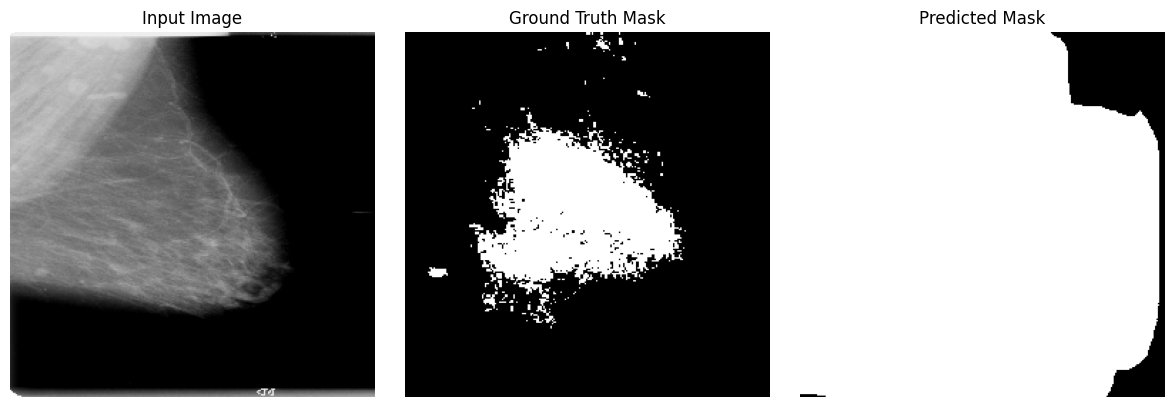

In [4]:
import matplotlib.pyplot as plt

def show_segmentation_triptych(model, dataloader, device, idx=0, threshold=0.5, save_path=None, wandb_log=False):
    model.eval()
    with torch.no_grad():
        batch = next(iter(dataloader))
        img = batch["image"][idx].unsqueeze(0).to(device)
        mask = batch["mask"][idx].squeeze().cpu().numpy()
        pred = torch.sigmoid(model(img)).cpu().squeeze().numpy()
        pred_mask = (pred > threshold).astype(float)
        input_img = img.cpu().squeeze().numpy()

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(input_img, cmap='gray')
        axs[0].set_title('Input Image')
        axs[1].imshow(mask, cmap='gray')
        axs[1].set_title('Ground Truth Mask')
        axs[2].imshow(pred_mask, cmap='gray')
        axs[2].set_title('Predicted Mask')
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150)
        if wandb_log:
            import wandb
            wandb.log({"Segmentation Triptych": wandb.Image(fig)})
        plt.show()

# Usage:
show_segmentation_triptych(model, test_loader, device, idx=0, save_path="triptych_best_run.png", wandb_log=False)
# import wandb
# wandb.init(project="classic_unet_seg_monai", name="triptych_visualization", reinit=True)
# show_segmentation_triptych(model, test_loader, device, idx=0, save_path="triptych_best_run.png", wandb_log=True)
# wandb.finish()
# import wandb
# wandb.init(project="classic_unet_seg_monai", name="triptych_visualization", reinit=True)
# show_segmentation_triptych(model, test_loader, device, idx=0, save_path="triptych_best_run.png", wandb_log=True)
# wandb.finish()